<a href="https://colab.research.google.com/github/azizamirsaidova/aws_disaster_response_hackathon/blob/main/Loss_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tornado Analysis and Magnitude Prediction

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
df=pd.read_csv('/content/Tornadoes_SPC_1950to2015.csv').rename({'yr':'Year','fat':'Fatalities','loss':'Property_Losses','inj':'Injuries','mag':'EF','closs':'Crop_Loss','st':'State'},axis=1)
df.head()

,om,Year,mo,dy,date,time,tz,State,stf,stn,EF,Injuries,Fatalities,Property_Losses,Crop_Loss,slat,slon,elat,elon,len,wid,fc
0,1,1950,1,3,1/3/1950,11:00:00,3,MO,29,1,3,3,0,6.0,0.0,38.77,-90.22,38.83,-90.03,9.5,150,0
1,2,1950,1,3,1/3/1950,11:55:00,3,IL,17,2,3,3,0,5.0,0.0,39.10,-89.30,39.12,-89.23,3.6,130,0
2,3,1950,1,3,1/3/1950,16:00:00,3,OH,39,1,1,1,0,4.0,0.0,40.88,-84.58,0.00,0.00,0.1,10,0
3,4,1950,1,13,1/13/1950,5:25:00,3,AR,5,1,3,1,1,3.0,0.0,34.40,-94.37,0.00,0.00,0.6,17,0
4,5,1950,1,25,1/25/1950,19:30:00,3,MO,29,2,2,5,0,5.0,0.0,37.60,-90.68,37.63,-90.65,2.3,300,0


In [13]:
df.describe()

,om,Year,mo,dy,tz,stf,stn,EF,Injuries,Fatalities,Property_Losses,Crop_Loss,slat,slon,elat,elon,len,wid,fc
count,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000
mean,41119.375753,1987.970057,5.972436,15.876368,3.001098,29.419919,26.476228,0.796154,1.561300,0.096866,2.159312,0.002134,37.155205,-92.961133,20.956247,-51.902893,3.480720,98.454603,0.030991
std,130865.993631,17.787883,2.388809,8.737193,0.077379,15.018850,32.672650,0.912341,19.177704,1.546215,20.284680,0.122182,5.123449,8.719121,18.890353,46.322703,8.519328,195.726277,0.173295
min,1.000000,1950.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.130000,-163.530000,0.000000,-163.530000,0.000000,0.000000,0.000000
25%,248.000000,1974.000000,4.000000,8.000000,3.000000,18.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.240000,-98.600000,0.000000,-94.250000,0.100000,13.000000,0.000000
50%,509.000000,1991.000000,6.000000,16.000000,3.000000,29.000000,15.000000,1.000000,0.000000,0.000000,0.100000,0.000000,37.085000,-93.950000,31.200000,-81.765000,0.600000,40.000000,0.000000
75%,845.000000,2003.000000,7.000000,24.000000,3.000000,45.000000,35.000000,1.000000,0.000000,0.000000,4.000000,0.000000,40.970000,-86.870000,38.150000,0.000000,3.000000,100.000000,0.000000
max,613494.000000,2015.000000,12.000000,31.000000,9.000000,72.000000,232.000000,5.000000,1740.000000,158.000000,2800.100000,23.520000,61.020000,-64.900000,61.020000,0.000000,234.700000,4576.000000,1.000000


In [14]:
df.isnull().sum()

om                 0
Year               0
mo                 0
dy                 0
date               0
time               0
tz                 0
State              0
stf                0
stn                0
EF                 0
Injuries           0
Fatalities         0
Property_Losses    0
Crop_Loss          0
slat               0
slon               0
elat               0
elon               0
len                0
wid                0
fc                 0
dtype: int64

In [16]:
df=df.copy()
df=df.drop(['date','stn','om','fc','tz','stf'],axis=1)
df['time']=pd.to_datetime(df['time'])
df['hour']=df['time'].apply(lambda x:x.hour)
df['minute']=df['time'].apply(lambda x:x.minute)
df=df.drop('time',axis=1)
df.head()

,Year,mo,dy,State,EF,Injuries,Fatalities,Property_Losses,Crop_Loss,slat,slon,elat,elon,len,wid,hour,minute
0,1950,1,3,MO,3,3,0,6.0,0.0,38.77,-90.22,38.83,-90.03,9.5,150,11,0
1,1950,1,3,IL,3,3,0,5.0,0.0,39.10,-89.30,39.12,-89.23,3.6,130,11,55
2,1950,1,3,OH,1,1,0,4.0,0.0,40.88,-84.58,0.00,0.00,0.1,10,16,0
3,1950,1,13,AR,3,1,1,3.0,0.0,34.40,-94.37,0.00,0.00,0.6,17,5,25
4,1950,1,25,MO,2,5,0,5.0,0.0,37.60,-90.68,37.63,-90.65,2.3,300,19,30


In [17]:
# for column in df.columns:
#     missing_cnt = df[column][df[column] == 0].count()
#     print('Zero/Unknown Values in column {col} = '.format(col = column) , missing_cnt )

In [18]:
df.loc[df['Year']<1996,['EF','Property_Losses']].head()

,EF,Property_Losses
0,3,6.0
1,3,5.0
2,1,4.0
3,3,3.0
4,2,5.0


In [19]:
df.loc[df['Year']>=1996,['EF','Property_Losses']].head()

,EF,Property_Losses
35431,0,0.04
35432,0,0.03
35433,0,0.00
35434,1,1.20
35435,0,0.10


In [20]:
df.loc[df['Year']<1996].groupby('EF')['Property_Losses'].agg([np.mean,np.max,np.std])

,mean,amax,std
EF,,,
0,1.230739,7.0,1.644207
1,3.216340,8.0,1.713685
2,4.015239,8.0,1.607244
3,4.749320,8.0,1.639328
4,5.480638,8.0,1.774750
5,5.822222,8.0,2.269250


In [21]:
df.loc[df['Year']>=1996].groupby('EF')['Property_Losses'].agg([np.mean,np.max,np.std])

,mean,amax,std
EF,,,
0,0.022021,30.0,0.345901
1,0.613716,750.0,13.243392
2,2.509558,400.0,13.900840
3,11.810541,500.0,32.949188
4,61.657143,2450.0,239.814954
5,553.441429,2800.1,891.524425


In [22]:
def LossApprox(cols):
    Loss=cols[0]
    EF=cols[1]
    Year=cols[2]
    if Year>1995:
        if Loss<0.00005:
            Loss=1
        elif Loss>=0.00005 and Loss<0.0005:
            Loss=2
        elif Loss>=0.0005 and Loss<0.005:
            Loss=3
        elif Loss>=0.005 and Loss<0.05:
            Loss=4
        elif Loss>=0.05 and Loss<0.5:
            Loss=5
        elif Loss>=0.5 and Loss<5: 
            Loss=6
        elif  Loss>=5 and Loss<50: 
            Loss=7
        elif Loss>=50 and Loss<500: 
            Loss=8
        elif Loss>=500 and Loss<5000: 
            Loss=9
    if Loss==0:
        if EF==0:
            Loss=1
        elif EF==1:
            Loss=3
        elif EF==2:
            Loss=4
        elif EF==3:
            Loss=5
        elif EF==4:
            Loss=6
        elif EF==5:
            Loss=7
    return int(Loss)
df['Property_Losses'] = df[['Property_Losses', 'EF','Year']].apply(LossApprox, axis=1)
print('Number of Missing Property Losses Values:')
print(df.loc[df['Property_Losses']==0,['EF','Year','Property_Losses']].head(10))
print('Property Losses after data processing:')
df.loc[:,['EF','Year','Property_Losses']].head()

Number of Missing Property Losses Values:
Empty DataFrame
Columns: [EF, Year, Property_Losses]
Index: []
Property Losses after data processing:


,EF,Year,Property_Losses
0,3,1950,6
1,3,1950,5
2,1,1950,4
3,3,1950,3
4,2,1950,5


In [23]:
df.loc[df['Year']<2005].groupby('EF')['Crop_Loss'].agg([np.mean,np.max,np.std])

,mean,amax,std
EF,,,
0,0.000000,0.0,0.000000
1,0.000000,0.0,0.000000
2,0.000051,0.4,0.004531
3,0.000000,0.0,0.000000
4,0.000000,0.0,0.000000
5,0.000000,0.0,0.000000


In [24]:
df.loc[df['Year']>2000].groupby('EF')['Crop_Loss'].agg([np.mean,np.max,np.std])

,mean,amax,std
EF,,,
0,0.000621,1.00,0.013499
1,0.004097,3.00,0.056363
2,0.024889,13.00,0.354368
3,0.057703,3.50,0.302729
4,0.402340,23.52,2.614833
5,0.025556,0.23,0.076667


In [25]:
def croplossapprox(cols):
    closs=cols[0]
    EF=cols[1]
    Year=cols[2]
    closs=closs*10**6
    if Year>1999:
        if closs<50:
            closs=1
        elif closs>=50 and closs<500:
            closs=2
        elif closs>=500 and closs<5000:
            closs=3
        elif closs>=5000 and closs<50000:
            closs=4
        elif closs>=50000 and closs<500000:
            closs=5
        elif closs>=500000 and closs<5000000:
            closs=6
        elif closs>=5000000 and closs<50000000:
            closs=7
    if closs==0:
        if EF==0:
            closs=3
        elif EF==1:
            closs=4
        elif EF==2:
            closs=4
        elif EF==3:
            closs=5
        elif EF==4:
            closs=6
        elif EF==5:
            closs=4
    return int(closs)
df['Crop_Loss'] = df[['Crop_Loss', 'EF','Year']].apply(croplossapprox, axis=1)
print('Number of Missing Crop Loss Values:')
print(df.loc[df['Crop_Loss']==0,['EF','Year','Crop_Loss']].head(10))
print('Property Losses after data processing:')
df.loc[:,['EF','Year','Crop_Loss']].head()

Number of Missing Crop Loss Values:
Empty DataFrame
Columns: [EF, Year, Crop_Loss]
Index: []
Property Losses after data processing:


,EF,Year,Crop_Loss
0,3,1950,5
1,3,1950,5
2,1,1950,4
3,3,1950,5
4,2,1950,4


In [26]:
df.describe()

,Year,mo,dy,EF,Injuries,Fatalities,Property_Losses,Crop_Loss,slat,slon,elat,elon,len,wid,hour,minute
count,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000
mean,1987.970057,5.972436,15.876368,0.796154,1.561300,0.096866,3.046079,2.832984,37.155205,-92.961133,20.956247,-51.902893,3.480720,98.454603,15.149050,25.350035
std,17.787883,2.388809,8.737193,0.912341,19.177704,1.546215,1.797828,1.355259,5.123449,8.719121,18.890353,46.322703,8.519328,195.726277,4.897992,17.714850
min,1950.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,18.130000,-163.530000,0.000000,-163.530000,0.000000,0.000000,0.000000,0.000000
25%,1974.000000,4.000000,8.000000,0.000000,0.000000,0.000000,1.000000,1.000000,33.240000,-98.600000,0.000000,-94.250000,0.100000,13.000000,13.000000,10.000000
50%,1991.000000,6.000000,16.000000,1.000000,0.000000,0.000000,3.000000,3.000000,37.085000,-93.950000,31.200000,-81.765000,0.600000,40.000000,16.000000,26.000000
75%,2003.000000,7.000000,24.000000,1.000000,0.000000,0.000000,5.000000,4.000000,40.970000,-86.870000,38.150000,0.000000,3.000000,100.000000,18.000000,40.000000
max,2015.000000,12.000000,31.000000,5.000000,1740.000000,158.000000,9.000000,7.000000,61.020000,-64.900000,61.020000,0.000000,234.700000,4576.000000,23.000000,59.000000


In [27]:
#Function to calculate no2 individual pollutant index(ni)
def calculate_ni(no2):
    ni=0
    if(no2<=40):
     ni= 1
    elif(no2>40 and no2<=80):
     ni= 2
    elif(no2>80 and no2<=120):
     ni= 3
    else:
     ni= 4
    return ni
df['death_score']=df['Fatalities'].apply(calculate_ni)
df.head()

,Year,mo,dy,State,EF,Injuries,Fatalities,Property_Losses,Crop_Loss,slat,slon,elat,elon,len,wid,hour,minute,death_score
0,1950,1,3,MO,3,3,0,6,5,38.77,-90.22,38.83,-90.03,9.5,150,11,0,1
1,1950,1,3,IL,3,3,0,5,5,39.10,-89.30,39.12,-89.23,3.6,130,11,55,1
2,1950,1,3,OH,1,1,0,4,4,40.88,-84.58,0.00,0.00,0.1,10,16,0,1
3,1950,1,13,AR,3,1,1,3,5,34.40,-94.37,0.00,0.00,0.6,17,5,25,1
4,1950,1,25,MO,2,5,0,5,4,37.60,-90.68,37.63,-90.65,2.3,300,19,30,1


In [28]:
#Function to calculate no2 individual pollutant index(ni)
def calculate_ni(no2):
    ni=0
    if(no2<=360):
     ni= 1
    elif(no2>360 and no2<=720):
     ni= 2
    elif(no2>720 and no2<=1080):
     ni= 3
    elif(no2>1080 and no2<=1440):
     ni= 4
    else:
     ni= 5
    return ni
df['Injury_Score']=df['Injuries'].apply(calculate_ni)


In [29]:
df.describe()

,Year,mo,dy,EF,Injuries,Fatalities,Property_Losses,Crop_Loss,slat,slon,elat,elon,len,wid,hour,minute,death_score,Injury_Score
count,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000
mean,1987.970057,5.972436,15.876368,0.796154,1.561300,0.096866,3.046079,2.832984,37.155205,-92.961133,20.956247,-51.902893,3.480720,98.454603,15.149050,25.350035,1.000299,1.000682
std,17.787883,2.388809,8.737193,0.912341,19.177704,1.546215,1.797828,1.355259,5.123449,8.719121,18.890353,46.322703,8.519328,195.726277,4.897992,17.714850,0.022338,0.038472
min,1950.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,18.130000,-163.530000,0.000000,-163.530000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1974.000000,4.000000,8.000000,0.000000,0.000000,0.000000,1.000000,1.000000,33.240000,-98.600000,0.000000,-94.250000,0.100000,13.000000,13.000000,10.000000,1.000000,1.000000
50%,1991.000000,6.000000,16.000000,1.000000,0.000000,0.000000,3.000000,3.000000,37.085000,-93.950000,31.200000,-81.765000,0.600000,40.000000,16.000000,26.000000,1.000000,1.000000
75%,2003.000000,7.000000,24.000000,1.000000,0.000000,0.000000,5.000000,4.000000,40.970000,-86.870000,38.150000,0.000000,3.000000,100.000000,18.000000,40.000000,1.000000,1.000000
max,2015.000000,12.000000,31.000000,5.000000,1740.000000,158.000000,9.000000,7.000000,61.020000,-64.900000,61.020000,0.000000,234.700000,4576.000000,23.000000,59.000000,4.000000,5.000000


In [30]:
df.columns

Index(['Year', 'mo', 'dy', 'State', 'EF', 'Injuries', 'Fatalities',
       'Property_Losses', 'Crop_Loss', 'slat', 'slon', 'elat', 'elon', 'len',
       'wid', 'hour', 'minute', 'death_score', 'Injury_Score'],
      dtype='object')

In [31]:
from sklearn.preprocessing import StandardScaler
cols_to_norm = ['death_score','Injury_Score','Crop_Loss','Property_Losses']
df[cols_to_norm] = StandardScaler().fit_transform(df[cols_to_norm])


In [32]:
#Function to calculate no2 individual pollutant index(ni)
def calculate_ni(no2):
    ni=0
    if(no2<=0.25):
     ni= 1
    elif(no2>0.25 and no2<=0.50):
     ni= 2
    elif(no2>0.50 and no2<=0.75):
     ni= 3
    else:
     ni= 4
    return ni
df['Injury_Score']=df['Injury_Score'].apply(calculate_ni)
df['death_score']=df['death_score'].apply(calculate_ni)
df['Crop_Loss']=df['Crop_Loss'].apply(calculate_ni)
df['Property_Losses']=df['Property_Losses'].apply(calculate_ni)



In [33]:
df['loss_score']=2*(df['death_score'])+ 1.5*(df['Injury_Score'])+df['Property_Losses']+0.5*(df['Crop_Loss'])

In [34]:
def calculate_ni(no2):
    ni=0
    if(no2<=5):
     ni= 1
    elif(no2>5 and no2<=10):
     ni= 2
    elif(no2>10 and no2<=15):
     ni= 3
    else:
     ni= 4
    return ni
df['loss_score']=df['loss_score'].apply(calculate_ni)

In [35]:
df['loss_score'].tail()

60109    1
60110    2
60111    2
60112    2
60113    2
Name: loss_score, dtype: int64

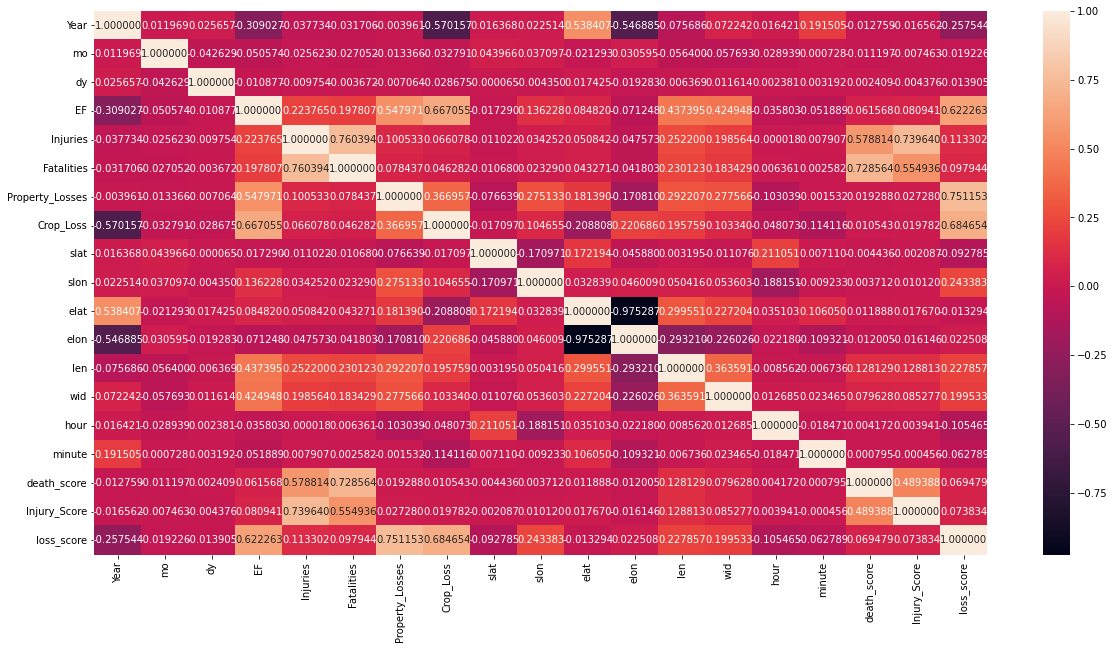

In [36]:
corr = df.corr()
corr = (corr)
a4_dims=(20,10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(corr,annot=True,fmt='f',xticklabels=corr.columns.values,yticklabels=corr.columns.values)

Text(336.9714285714286, 0.5, 'Tornado Magnitude in EF Scale')

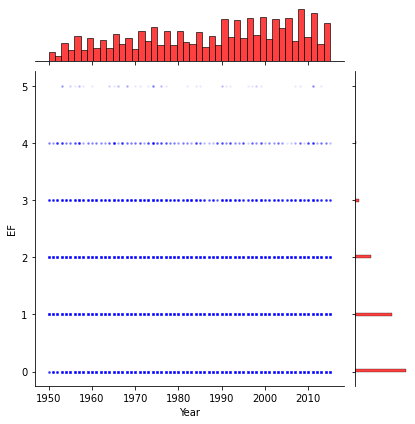

In [37]:
sns.jointplot(x=df['Year'],y=df['EF'],joint_kws={'alpha':0.1,'s':5,'color':'blue'},marginal_kws={'color':'red'})
fig.suptitle("Tornado Magnitude in EF Scale vs Year")
plt.xlabel('Year')
plt.ylabel('Tornado Magnitude in EF Scale')


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


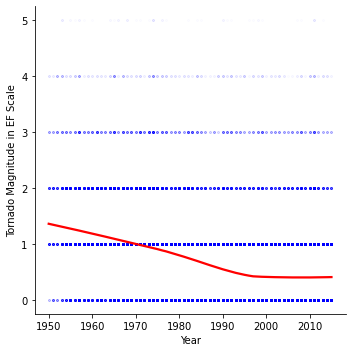

In [38]:
sns.lmplot(data=df,x='Year',y='EF',lowess=True,scatter_kws={'alpha':0.01,'s':5,'color':'blue'},line_kws={'color':'red'})
fig.suptitle("Tornado Magnitude in EF Scale vs Year")
plt.xlabel('Year')
plt.ylabel('Tornado Magnitude in EF Scale')
plt.show()

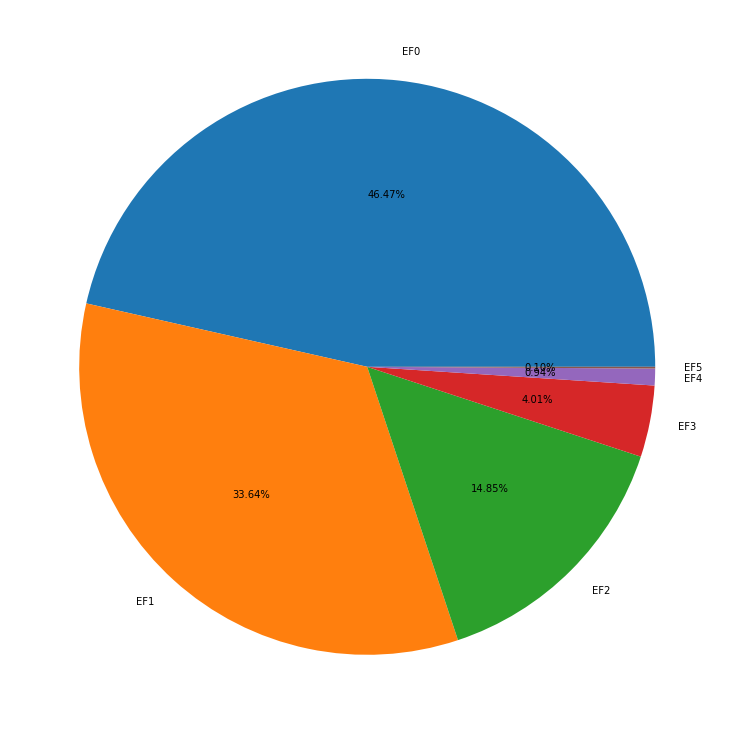

In [39]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
Mag = ['EF0', 'EF1', 'EF2', 'EF3', 'EF4','EF5']
ax.pie(df['EF'].value_counts(), labels = Mag,autopct='%1.2f%%')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


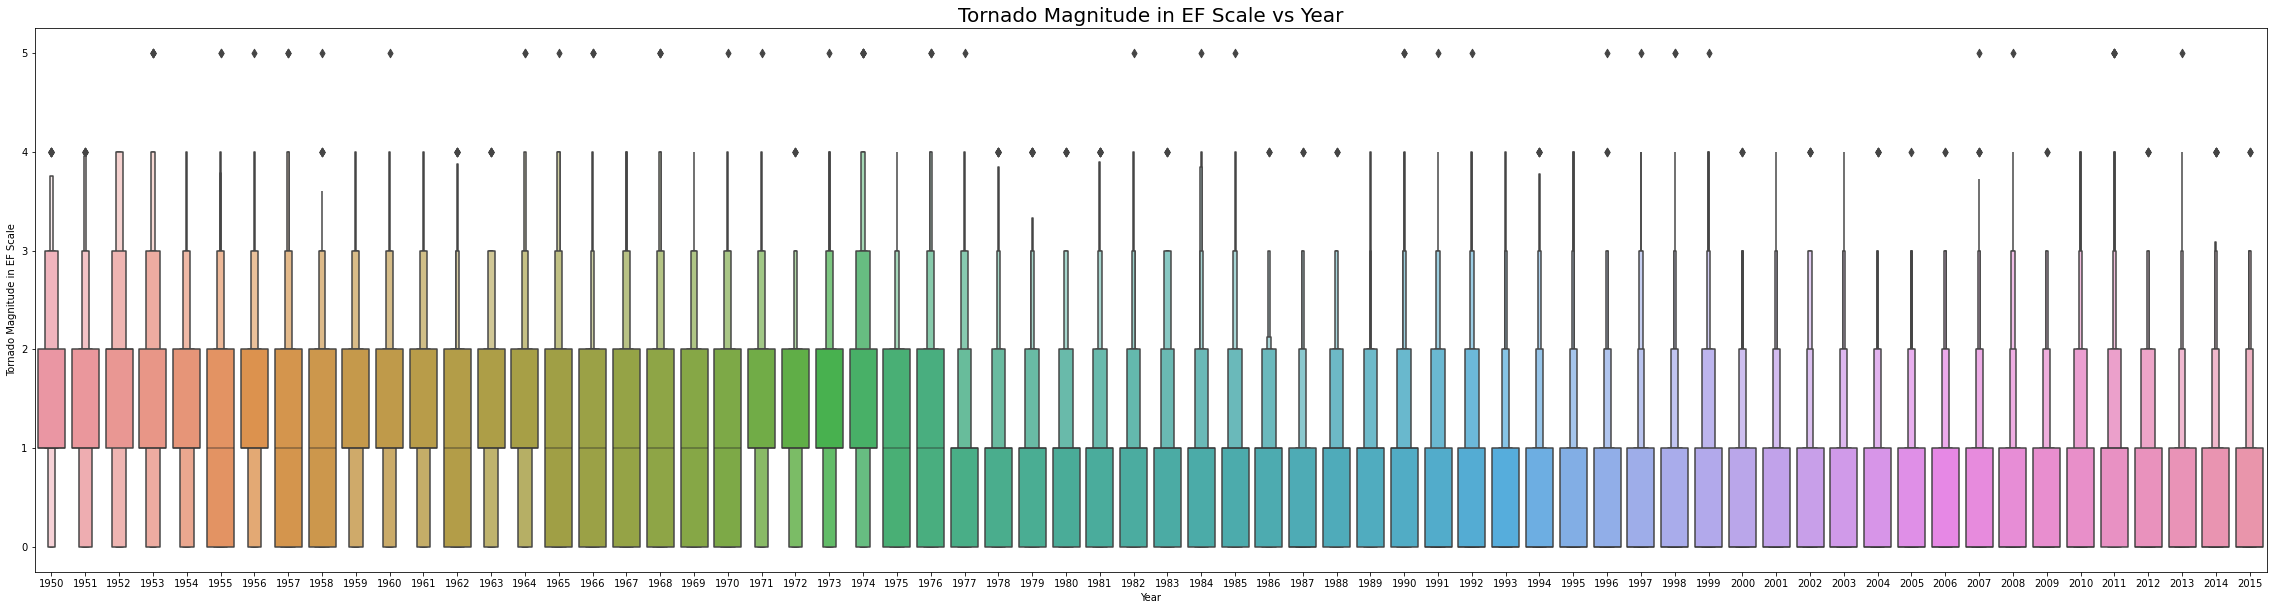

In [40]:
plt.rcParams['figure.figsize']=(40, 10)
plt.style.use('seaborn-dark-palette')
sns.boxenplot(df['Year'],df['EF'])
plt.xlabel('Year')
plt.ylabel('Tornado Magnitude in EF Scale')
plt.title('Tornado Magnitude in EF Scale vs Year',fontsize=20)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


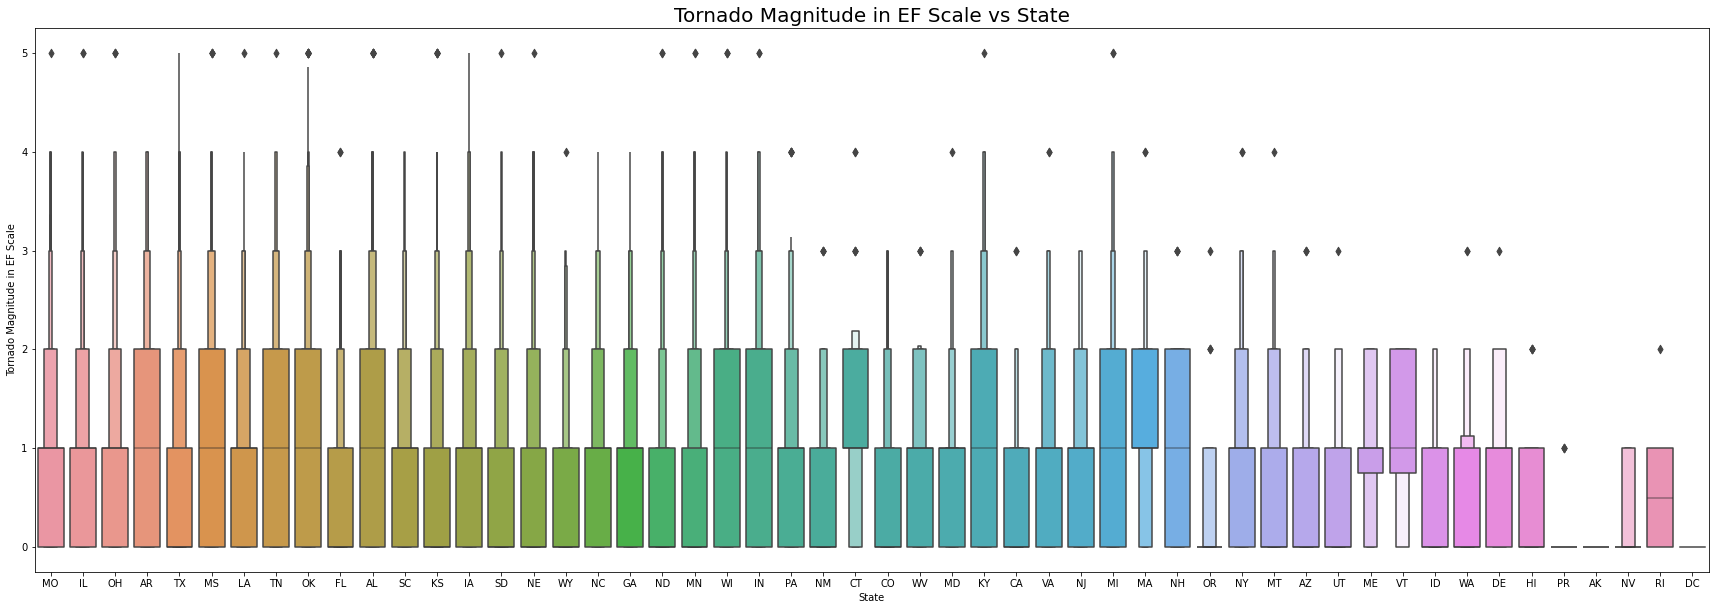

In [41]:
plt.rcParams['figure.figsize']=(30, 10)
plt.style.use('seaborn-dark-palette')
sns.boxenplot(df['State'],df['EF'])
plt.title('Tornado Magnitude in EF Scale vs State',fontsize=20)
plt.xlabel('State')
plt.ylabel('Tornado Magnitude in EF Scale')
plt.show()

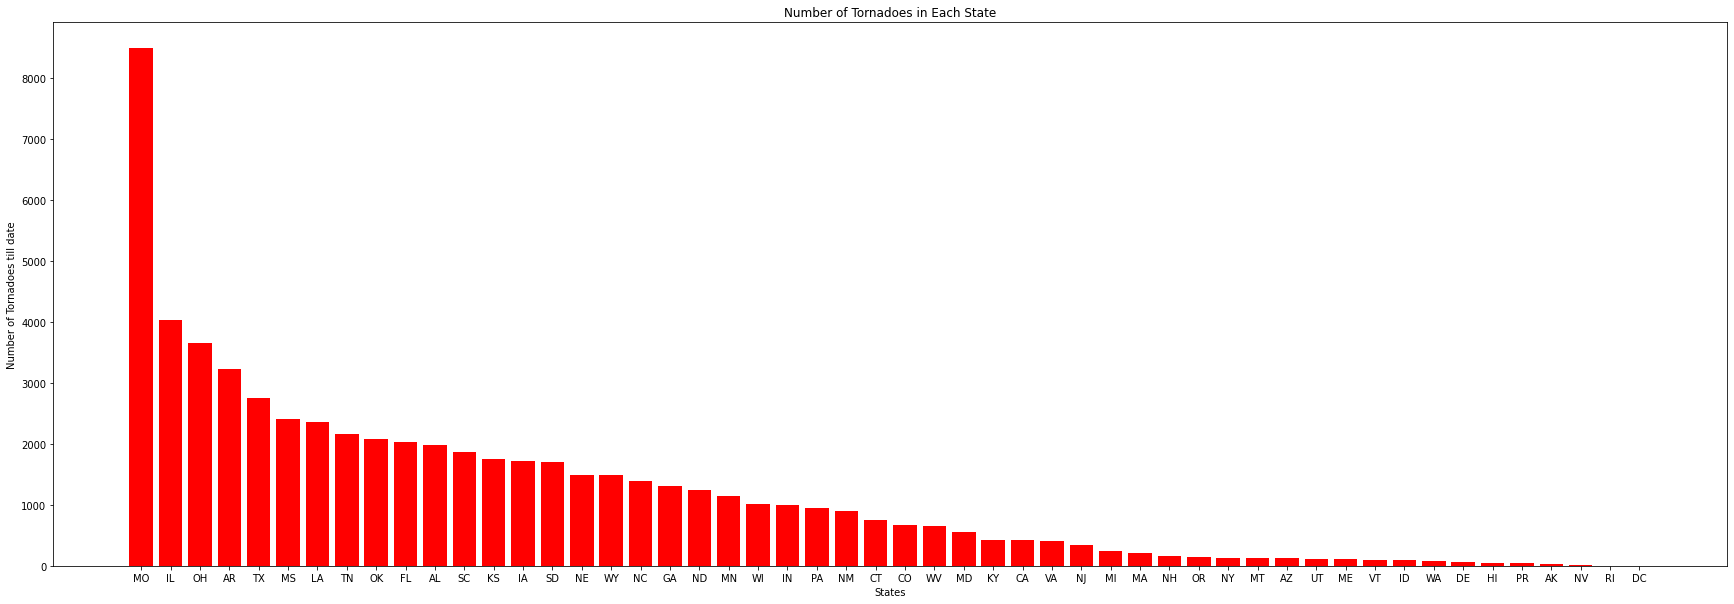

In [42]:
plt.style.use('seaborn-dark-palette')
plt.bar(df['State'].unique(),df['State'].value_counts(),color='r')
plt.xlabel('States')
plt.ylabel('Number of Tornadoes till date')
plt.title('Number of Tornadoes in Each State')
plt.show()